In [1]:
# unit tests


In [2]:


def create_grid(rows, cols, drow, dcol, intensity=255):    
    a = np.zeros((rows, cols), dtype=np.int)
    for i in range(rows):
        if i%drow == 0:
            a[::, i:i+1] = intensity
    for j in range(cols):
        if j%dcol == 0:
            a[j:j + 1, ::] = intensity
 
    return a

def box(a, x, y, w, h, intensity):
#    print(">>>>>>>>>box", x, y, w, h, intensity)
    a[x : x+w, y : y + 1] = intensity
    a[x : x+w, y + h - 1 : y + h] = intensity
    a[x : x + 1, y : y + h] = intensity
    a[x + w -1: x + w, y : y + h] = intensity
    
def create_boxes(rows, cols, boxdx, boxdy, boxw, boxh, intensity=255):
    a = np.zeros((rows, cols), dtype=np.int)
    for i in range(rows):
        x0 = boxdx * i
        for j in range(cols):
            y0 = boxdy * j
            box(a, boxdx, boxdy, boxw, boxh, intensity)
    return a
        
def create_skeleton(image_file):
    import labels
    binary = labels.thin_skeleton_file(image_file)
    return binary

In [3]:
def convolve2d(a, kernel):
    """Maybe not used"""
    import scipy.signal.convolve2d as convolve2d
#    convolved = np.asmatrix(convolve2d(a,kernel,'same'))
    convolved = convolve2d(a,kernel,'same')
    
    return convolved

In [4]:
def convolve_normalize_transpose(grid, kernel):
    from scipy import ndimage
#    scipy.ndimage.convolve(input, weights, output=None, mode='reflect', cval=0.0, origin=0)

    if np.any(grid)==None:
        print("grid missing")
        return
    if np.any(kernel)==None:
        print("kernel missing")
        return
    print("grid sh", grid.shape, "ty", type(grid[0:1,0:1]), type(grid[0,0]))
    convolved = ndimage.convolve(grid, kernel)
    max = np.max(convolved)
    # normalize to grayscale
    convolved = np.where(convolved < max/2 , 0, convolved)
    convolved = np.where(convolved < 0 , 0, convolved)
    print("Convolved sh", convolved.shape, "ty", type(convolved[0:1,0:1]), type(convolved[0,0]))
    convolved_t = np.transpose(convolved)
    return convolved, convolved_t

def convolve_and_plot(grid, kernel, title=None):
    from PIL import Image
    convolved, convolved_t = convolve_normalize_transpose(grid, kernel)
    plot(convolved)
#    img = Image.fromarray(convolved)
#    img.save(title+".png")

#    plot(convolved_t)


In [5]:
def plot(myarray):
    import matplotlib.pyplot as plt
    plt.imshow(myarray)
    plt.show()
    
def plot_file(file):
    array = Image.open(file, "r")
    plot(array)

In [6]:
import numpy as np

def normalize_box(box):
    """ adds offset to normalize sum = zero """
    area = box.shape[0] * box.shape[1]
    newbox = box - np.sum(box) / area
    return newbox
        
def create_array_kernel(name, data_array):
    array = normalize_box(data_array)
    return array

def create_kernel(name, width=None, height=None, linewidth=1, intens=1):
    if width==None or height==None:
        raise Exception("must give width and height") 

    def hhlw(d, lw):
        hw = (d + 1) // 2
        hlw = (lw + 1) // 2 
        return hw,hlw

    def rect(w, h, lw, intens):
        box = np.zeros((width, height))
        box[0:lw, ::] = intens
        box[w - lw, ::] = intens
        box[::, 0:lw] = intens
        box[::, h-lw:h] = intens
        return box
        
    def vert(w, h, lw, intens):
        box = np.zeros((w, h))
        hw, hlw = hhlw(h, lw)
        box[hw - hlw : hw + hlw - 1, ::] = intens
        return box
        
    def horiz(w, h, lw, intens):
        box = np.zeros((w, h))
        hw, hlw = hhlw(w, lw)
        box[::, hw - hlw : hw + hlw - 1] = intens
        return box
        
    def cross(w, h, lw, intens):
        box = np.zeros((width, height))
        hw = (w + 1) // 2
        hh = (h + 1) // 2
        hlw = (lw + 1) // 2 
        box[hw - hlw : hw + hlw - 1, ::] = intens
        box[::, hh - hlw : hh + hlw - 1] = intens
        return box
    
    kernels = {
        "rect": rect(width, height, linewidth, intens),
        "horiz": horiz(width, height, linewidth, intens),
        "vert": vert(width, height, linewidth, intens),
        "cross": cross(width, height, linewidth, intens=3),
    }
    
    func = kernels[name]
    box = func
    new_box = normalize_box(box)
    return new_box

def create_small_grid():
    grid = np.ones((10,15))*100
    grid[1:4,1:3] = 0
    grid[5:8,1:3] = 0
    grid[1:4,4:6] = 0
    grid[5:8,4:6] = 0
    grid[1:4,7:9] = 0
    grid[5:8,7:9] = 0
    grid[1:4,10:12] = 0
    grid[5:8,10:12] = 0
    grid[1:4,13:15] = 0
    grid[5:8,13:15] = 0
    


rect
grid sh (129, 137) ty <class 'numpy.ndarray'> <class 'numpy.int64'>
Convolved sh (129, 137) ty <class 'numpy.ndarray'> <class 'numpy.int64'>


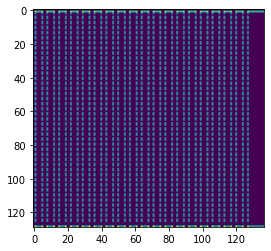

In [7]:
def smalltest():
    halfw = 2
    import os
    import numpy as np
    from scipy import ndimage
    from PIL import Image

    float_formatter = "{:.2f}".format
    np.set_printoptions(formatter={'float_kind':float_formatter})

    gridw = 129
    gridh = 137
    grid = create_grid(gridw, gridh, 7, 3)

    print("rect")
    rect_kernel = create_kernel("rect", 5, 4)
    convolve_and_plot(grid, rect_kernel)
    return
    print("cross")
    cross_kernel = create_kernel("cross", 5, 7, intens=3)
    convolve_and_plot(grid, cross_kernel)
    print("horiz")
    horiz_kernel = create_kernel("horiz", 5, 5)
    convolve_and_plot(grid, horiz_kernel)
    print("vert")
    vert_kernel = create_kernel("vert", 5, 5)
    convolve_and_plot(grid, vert_kernel)

    mydata = np.array([
        [1, 1, 0, 1, 1],
        [1, 0, 0, 0, 1],
        [1, 0, 0, 0, 1],
        [1, 1, 0, 1, 1],
    ])    

    print("[]")
    kernel = create_array_kernel("[]", mydata)

    convolve_and_plot(grid, kernel)

    print("===FINISHED smalltest===")
smalltest()



In [8]:
def old_plot():
    """probably abandon"""
    from matplotlib import pyplot as plt
    grid = create_boxes(4, 5, 5, 6, 3, 4)
    print("grid", grid.shape, "\n", grid)
    plt.imshow(grid)
    plt.show()


    convolved = plot_convolve(grid, kernel)

    from matplotlib import pyplot as plt
    # plt.imshow(grid_points, interpolation='nearest')
    plt.imshow(grid)
    plt.show()
    plt.imshow(convolved,cmap='gray', vmin=0, vmax=255)
    plt.show()

vert - 3 - 3
grid sh (546, 1354) ty <class 'numpy.ndarray'> <class 'numpy.bool_'>
Convolved sh (546, 1354) ty <class 'numpy.ndarray'> <class 'numpy.int64'>


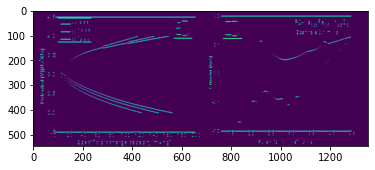

vert - 3 - 5
grid sh (546, 1354) ty <class 'numpy.ndarray'> <class 'numpy.bool_'>
Convolved sh (546, 1354) ty <class 'numpy.ndarray'> <class 'numpy.int64'>


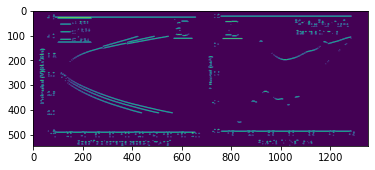

vert - 3 - 7
grid sh (546, 1354) ty <class 'numpy.ndarray'> <class 'numpy.bool_'>
Convolved sh (546, 1354) ty <class 'numpy.ndarray'> <class 'numpy.int64'>


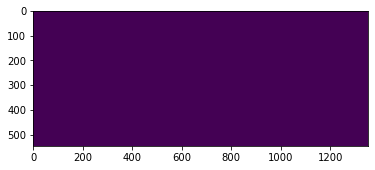

vert - 5 - 3
grid sh (546, 1354) ty <class 'numpy.ndarray'> <class 'numpy.bool_'>
Convolved sh (546, 1354) ty <class 'numpy.ndarray'> <class 'numpy.int64'>


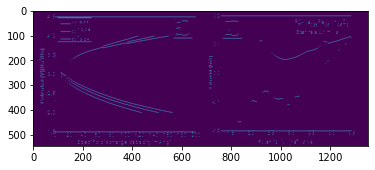

vert - 5 - 5
grid sh (546, 1354) ty <class 'numpy.ndarray'> <class 'numpy.bool_'>
Convolved sh (546, 1354) ty <class 'numpy.ndarray'> <class 'numpy.int64'>


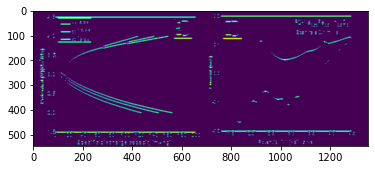

vert - 5 - 7
grid sh (546, 1354) ty <class 'numpy.ndarray'> <class 'numpy.bool_'>
Convolved sh (546, 1354) ty <class 'numpy.ndarray'> <class 'numpy.int64'>


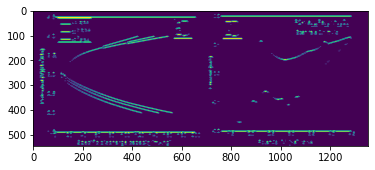

vert - 7 - 3
grid sh (546, 1354) ty <class 'numpy.ndarray'> <class 'numpy.bool_'>
Convolved sh (546, 1354) ty <class 'numpy.ndarray'> <class 'numpy.int64'>


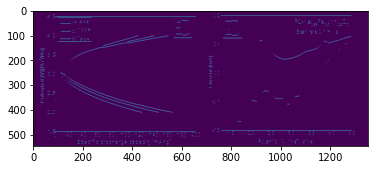

vert - 7 - 5
grid sh (546, 1354) ty <class 'numpy.ndarray'> <class 'numpy.bool_'>
Convolved sh (546, 1354) ty <class 'numpy.ndarray'> <class 'numpy.int64'>


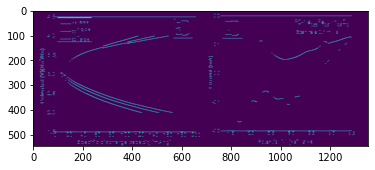

vert - 7 - 7
grid sh (546, 1354) ty <class 'numpy.ndarray'> <class 'numpy.bool_'>
Convolved sh (546, 1354) ty <class 'numpy.ndarray'> <class 'numpy.int64'>


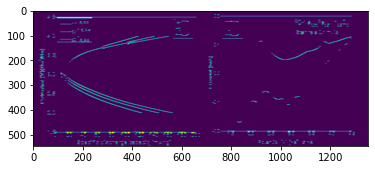

horiz - 3 - 3
grid sh (546, 1354) ty <class 'numpy.ndarray'> <class 'numpy.bool_'>
Convolved sh (546, 1354) ty <class 'numpy.ndarray'> <class 'numpy.int64'>


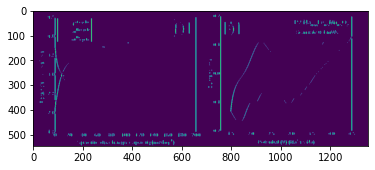

horiz - 3 - 5
grid sh (546, 1354) ty <class 'numpy.ndarray'> <class 'numpy.bool_'>
Convolved sh (546, 1354) ty <class 'numpy.ndarray'> <class 'numpy.int64'>


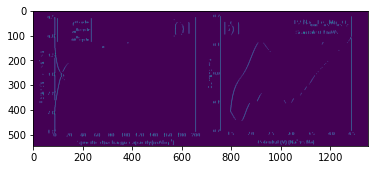

horiz - 3 - 7
grid sh (546, 1354) ty <class 'numpy.ndarray'> <class 'numpy.bool_'>
Convolved sh (546, 1354) ty <class 'numpy.ndarray'> <class 'numpy.int64'>


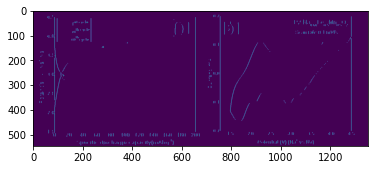

horiz - 5 - 3
grid sh (546, 1354) ty <class 'numpy.ndarray'> <class 'numpy.bool_'>
Convolved sh (546, 1354) ty <class 'numpy.ndarray'> <class 'numpy.int64'>


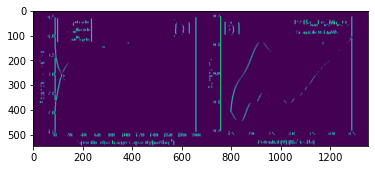

horiz - 5 - 5
grid sh (546, 1354) ty <class 'numpy.ndarray'> <class 'numpy.bool_'>
Convolved sh (546, 1354) ty <class 'numpy.ndarray'> <class 'numpy.int64'>


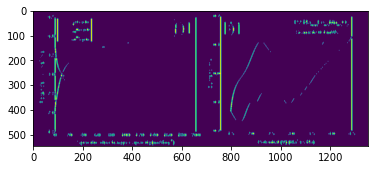

horiz - 5 - 7
grid sh (546, 1354) ty <class 'numpy.ndarray'> <class 'numpy.bool_'>
Convolved sh (546, 1354) ty <class 'numpy.ndarray'> <class 'numpy.int64'>


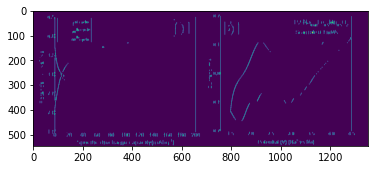

horiz - 7 - 3
grid sh (546, 1354) ty <class 'numpy.ndarray'> <class 'numpy.bool_'>
Convolved sh (546, 1354) ty <class 'numpy.ndarray'> <class 'numpy.int64'>


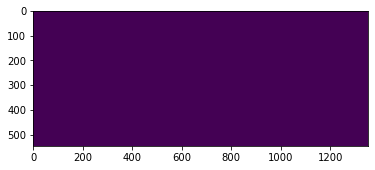

horiz - 7 - 5
grid sh (546, 1354) ty <class 'numpy.ndarray'> <class 'numpy.bool_'>
Convolved sh (546, 1354) ty <class 'numpy.ndarray'> <class 'numpy.int64'>


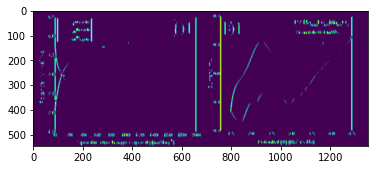

horiz - 7 - 7
grid sh (546, 1354) ty <class 'numpy.ndarray'> <class 'numpy.bool_'>
Convolved sh (546, 1354) ty <class 'numpy.ndarray'> <class 'numpy.int64'>


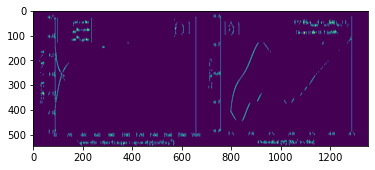

In [9]:
def plot_conv(title, w, h):
    print(title, "-", w, "-", h)
    plot_pdfimages(create_kernel(title, w, h), title + str(i)+"-"+str(j)+".png")
    return

def plot_pdfimages(kernel, title):
    import os
    from PIL import Image
    from matplotlib import pyplot as plt
    
    HOME = os.path.expanduser("~")
    file = os.path.join(HOME, 
        'workspace/jupyter/physchem/liion/PMC7077619/pdfimages/image.8.3.81_523.164_342/raw.png')
#    plot(file)
    if not os.path.isfile(file):
        print("nonexistent ", file)
        return
    skeleton = create_skeleton(file)
    
#    print ("skeleton", type(skeleton), type(skeleton[0:1, 0:1]), "\n", skeleton)
    convolve_and_plot(skeleton, kernel, title);

    
for i in range(3, 9, 2):
    for j in range(3, 9, 2):
        plot_conv("vert", i, j)

print("===========================")

for i in range(3, 9, 2):
    for j in range(3, 9, 2):
        plot_conv("horiz", i, j)
